In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import nltk
from nltk.collocations import *
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Смотрим на датасет

In [2]:
dfemails = pd.read_csv("./datasets/hillary-clinton-emails/Emails.csv")
dfreceivers = pd.read_csv("./datasets/hillary-clinton-emails/EmailReceivers.csv")

In [3]:
dfemails[:2]

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


Наибольший интерес представляет сам текст письма, его можно получить из поля "ExtractedBodyText" или попробовать самому руками выделить из "RawText". Кажется, что лучше, чем в "ExtractedBodyText" не получится, поэтому попробуем взять егго :)

In [4]:
dfemails[:1]["RawText"][0].split("\n")

['UNCLASSIFIED\r',
 'U.S. Department of State\r',
 'Case No. F-2015-04841\r',
 'Doc No. C05739545\r',
 'Date: 05/13/2015\r',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\r',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\r',
 'RELEASE IN FULL\r',
 'From: Sullivan, Jacob J <Sullivan11@state.gov>\r',
 'Sent: Wednesday, September 12, 2012 10:16 AM\r',
 'To:\r',
 'Subject: FW: Wow\r',
 'From: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi\r',
 'Sent: Wednesday, September 12, 2012 10:09 AM\r',
 'To: Sullivan, Jacob J\r',
 'Subject: Wow\r',
 'What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me\r',
 'too\r',
 'UNCLASSIFIED\r',
 'U.S. Department of State\r',
 'Case No. F-2015-04841\r',
 'Doc No. C05739545\r',
 'Date: 05/13/2015\r',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\r',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. 

In [5]:
for i in dfemails[:5]["ExtractedBodyText"]:
    print(str(i) + "\n")

nan

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary

Thx

nan

H <hrod17@clintonemail.com>
Friday, March 11, 2011 1:36 PM
Huma Abedin
Fw: H: Latest: How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx
Pis print.



### Вырезаем то, что нам интересно

В письмах интереснее всего (для восприятия человеком), кто написал, кому и что. Попробуем составить датасет с такими колонками "from", "to", "text"

In [6]:
df = pd.DataFrame({'from': dfemails["SenderPersonId"],
                   'to': [" ".join(map(str, dfreceivers.loc[dfreceivers["EmailId"] == emailId]["PersonId"])) for emailId in dfemails["Id"]],
                   'text': dfemails["ExtractedBodyText"]})

In [7]:
df[:5]

,from,text,to
0,87.0,NaN,80
1,NaN,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",80
2,32.0,Thx,228 80
3,32.0,NaN,80
4,80.0,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",81


Заметим, что у нас неправильные типы в первой колонке и что текст, отправитель и получатели иногда отсутствует, поправим это

In [8]:
df['from'].fillna(0, inplace=True)
df['text'].fillna('', inplace=True)
df['to'].fillna('', inplace=True)

df[:5]

,from,text,to
0,87.0,,80
1,0.0,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",80
2,32.0,Thx,228 80
3,32.0,,80
4,80.0,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",81


In [9]:
df['from'] = df['from'].astype(int)
df[:5]

,from,text,to
0,87,,80
1,0,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",80
2,32,Thx,228 80
3,32,,80
4,80,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",81


Теперь все верно

### Найдем самые частые биграммы

In [10]:
vectorizer = CountVectorizer(ngram_range = (2, 2), stop_words = 'english', min_df = 10)
X = vectorizer.fit_transform(df['text'])

Добавили stop_words = 'english', потому что иначе топ из частот биграм был полон прелогов с артиклями: to the, for the и т д

Теперь найдем топ-10 биграм

In [11]:
bigramFreq = list(zip(vectorizer.get_feature_names(), np.asarray(X.sum(axis=0)).ravel()))
bigramFreq.sort(key = lambda t: t[1], reverse = True)

bigramFreq[:10]

[('state gov', 761),
 ('secretary office', 460),
 ('state department', 455),
 ('united states', 449),
 ('00 pm', 447),
 ('white house', 424),
 ('30 pm', 337),
 ('en route', 315),
 ('department state', 293),
 ('pm secretary', 278)]

### NLTK

Вспомогательная функция, которой нет в Python 3 :(

In [12]:
flatten = lambda l: [item for sublist in l for item in sublist]

Парсим предложения их каждого письма и затеи парсим их на слова с помощью NLTK

In [13]:
nltk.download('punkt')
tokenizedSent = [sent_tokenize(emailText) for emailText in df['text']]
tokenizedWords = [word_tokenize(tokenizedSent) for tokenizedSent in flatten(tokenizedSent)]
tokenizedWords[:2]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['B6',
  'Thursday',
  ',',
  'March',
  '3',
  ',',
  '2011',
  '9:45',
  'PM',
  'H',
  ':',
  'Latest',
  'How',
  'Syria',
  'is',
  'aiding',
  'Qaddafi',
  'and',
  'more',
  '...',
  'Sid',
  'hrc',
  'memo',
  'syria',
  'aiding',
  'libya',
  '030311.docx',
  ';',
  'hrc',
  'memo',
  'syria',
  'aiding',
  'libya',
  '030311.docx',
  'March',
  '3',
  ',',
  '2011',
  'For',
  ':',
  'Hillary'],
 ['Thx']]

In [14]:
bigramMeasures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(tokenizedWords)
finder.nbest(bigramMeasures.pmi, 10)

[("'1.com", 'aeirig'),
 ("'1HE", ".i't"),
 ("'Banish", 'Sexual'),
 ("'H", 'CCL'),
 ("'Li", 'Matou'),
 ("'Stone", 'Harbour'),
 ("'bad", 'talkers'),
 ("'badly", "trained'"),
 ("'civ", 'cas'),
 ("'ffrjend", 'nieei')]

Результат немного странный :) Возможно стоит подумать над тем, как почистить тексты

### Кластеризация

In [15]:
tfIdfVectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = tfIdfVectorizer.fit_transform(df['text'])

In [16]:
matrix.shape

(7945, 4299)

In [29]:
clusterCount = 7

In [30]:
# тут можно идти пить чай
model = AgglomerativeClustering(n_clusters = clusterCount, affinity = 'euclidean', linkage = 'complete')
clusterPredictions = model.fit_predict(matrix.toarray())

In [31]:
clusterPredictions[:30]

array([3, 1, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 0, 1, 0, 5, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 3, 1, 0, 1], dtype=int64)

### Визуализация

In [32]:
svd = TruncatedSVD(n_components=3).fit(matrix)
svd_2d = svd.transform(matrix)

In [33]:
svd_2d.shape
print(type(svd_2d[:2]))
len(svd_2d)

<class 'numpy.ndarray'>


7945

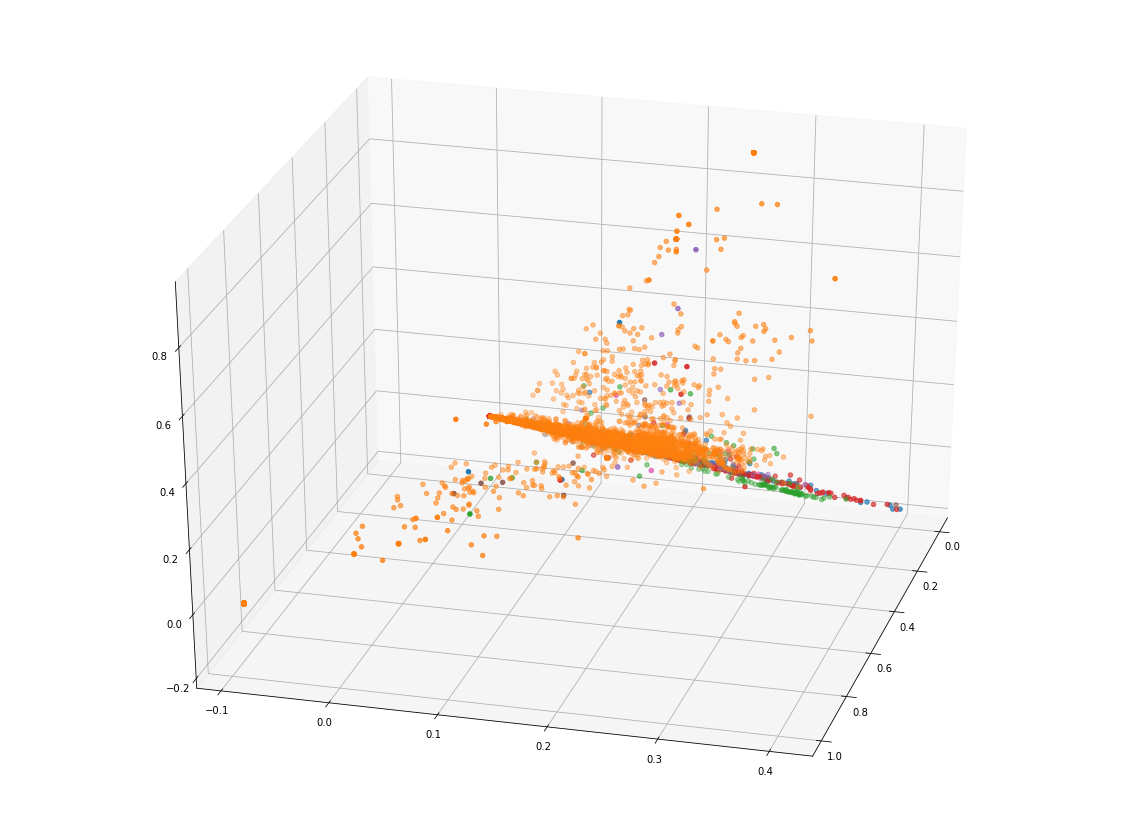

In [34]:
fig_size = [20, 15]
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for clusterIndex in range(0, clusterCount):
    svd_2d_cluster = np.array([np.array(svd_2d[i]) for i in range(0, len(svd_2d)) if clusterPredictions[i] == clusterIndex])
    x = svd_2d_cluster[:,0]
    y = svd_2d_cluster[:,1]
    z = svd_2d_cluster[:,2]
    ax.scatter(x, y, z)

ax.view_init(30, 15)
plt.show()

Как ни крути, тяжело разобрать, что происходит :(